# Filtering, reformatting and adding metadata to downsampled variants

This notebook includes the first steps of downstream processing for vcf files generated with freebayes (https://github.com/ekg/freebayes), filtered with vcffilter and annotated with SnpEff. The input files are tab delimited text files generated from annotated vcf files using SnpSift, with only the first annotation for each variant considered. The processing includes reformatting data tables, filtering variants and adding metadata to create a master data table containing a golden set of variants.

In [1]:
# Housekeeping

library(ggplot2)
library(reshape2)

In [2]:
# Read in variant data (SNPs, MNPs and indels)

files = list.files("../../../data/deep_seq/downsampled_variant_data/", full.names = T)
filenames = gsub(".txt", "", basename(files))
variant_list = lapply(files, read.table,header = T, check.names = F)
names(variant_list) = filenames
head(variant_list[[1]])

CHROM,POS,REF,ALT,TYPE,ANN[0].EFFECT,ANN[0].IMPACT,ANN[0].GENE,ANN[0].GENEID,ANN[0].HGVS_C,ANN[0].HGVS_P,GEN[*].AD
JFDMDMML_1,102233,A,G,snp,synonymous_variant,LOW,hag_2,JFDMDMML_00111,c.759A>G,p.Leu253Leu,"0,4"
JFDMDMML_1,102275,C,T,snp,synonymous_variant,LOW,hag_2,JFDMDMML_00111,c.801C>T,p.Ser267Ser,"0,7"
JFDMDMML_1,102281,G,C,snp,synonymous_variant,LOW,hag_2,JFDMDMML_00111,c.807G>C,p.Thr269Thr,"0,7"
JFDMDMML_1,102302,G,A,snp,synonymous_variant,LOW,hag_2,JFDMDMML_00111,c.828G>A,p.Gln276Gln,"0,6"
JFDMDMML_1,540043,CTT,CT,del,downstream_gene_variant,MODIFIER,exbB_1,JFDMDMML_00506,c.*4852delT,NA,"0,3"
JFDMDMML_3,98,T,C,snp,upstream_gene_variant,MODIFIER,metN_2,JFDMDMML_00998,c.-933T>C,NA,"0,6"


In [3]:
# Rename columns including adding sample id

variant_list2 = list()
for(i in 1:length(variant_list)){
  a = variant_list[[i]]
  colnames(a) = c("CHROM", "POS", "REF", "ALT", "TYPE", "EFFECT", "IMPACT", "GENE", "GENEID", "HGVS_C", "HGVS_P", names(variant_list[i]))  
  variant_list2[[i]] = a
}
names(variant_list2)=filenames

head(variant_list2[[1]])

CHROM,POS,REF,ALT,TYPE,EFFECT,IMPACT,GENE,GENEID,HGVS_C,HGVS_P,T12_AB0_I0_REP1
JFDMDMML_1,102233,A,G,snp,synonymous_variant,LOW,hag_2,JFDMDMML_00111,c.759A>G,p.Leu253Leu,"0,4"
JFDMDMML_1,102275,C,T,snp,synonymous_variant,LOW,hag_2,JFDMDMML_00111,c.801C>T,p.Ser267Ser,"0,7"
JFDMDMML_1,102281,G,C,snp,synonymous_variant,LOW,hag_2,JFDMDMML_00111,c.807G>C,p.Thr269Thr,"0,7"
JFDMDMML_1,102302,G,A,snp,synonymous_variant,LOW,hag_2,JFDMDMML_00111,c.828G>A,p.Gln276Gln,"0,6"
JFDMDMML_1,540043,CTT,CT,del,downstream_gene_variant,MODIFIER,exbB_1,JFDMDMML_00506,c.*4852delT,NA,"0,3"
JFDMDMML_3,98,T,C,snp,upstream_gene_variant,MODIFIER,metN_2,JFDMDMML_00998,c.-933T>C,NA,"0,6"


In [4]:
# Convert read count data to proportions and modify column names

options(warn = -1) # inactivate warnings to avoid NA alerts

dim(variant_list2[[1]])
variant_list3 = list()
for(i in 1:length(variant_list2)){
    a = variant_list2[[i]]
    c = vector(mode = "numeric", length = length(a[, 12]))
    for(j in 1:nrow(a)){
      b = as.character(a[j, 12])
      b = as.numeric(unlist(strsplit(b, ",", fixed = T)))
      b = ifelse(is.na(b) == T, NA, b[2] / sum(b))
      c[j] = b
      }
    a[, 12] = c
    a[, 12] = as.numeric(a[, 12])
    variant_list3[[i]] = a
}

options(warn = 0) # reactivate warnings

head(variant_list3[[1]])

[1] 269  12

CHROM,POS,REF,ALT,TYPE,EFFECT,IMPACT,GENE,GENEID,HGVS_C,HGVS_P,T12_AB0_I0_REP1
JFDMDMML_1,102233,A,G,snp,synonymous_variant,LOW,hag_2,JFDMDMML_00111,c.759A>G,p.Leu253Leu,1
JFDMDMML_1,102275,C,T,snp,synonymous_variant,LOW,hag_2,JFDMDMML_00111,c.801C>T,p.Ser267Ser,1
JFDMDMML_1,102281,G,C,snp,synonymous_variant,LOW,hag_2,JFDMDMML_00111,c.807G>C,p.Thr269Thr,1
JFDMDMML_1,102302,G,A,snp,synonymous_variant,LOW,hag_2,JFDMDMML_00111,c.828G>A,p.Gln276Gln,1
JFDMDMML_1,540043,CTT,CT,del,downstream_gene_variant,MODIFIER,exbB_1,JFDMDMML_00506,c.*4852delT,NA,1
JFDMDMML_3,98,T,C,snp,upstream_gene_variant,MODIFIER,metN_2,JFDMDMML_00998,c.-933T>C,NA,1


In [5]:
# Convert read count data to total read depth and modify column names

options(warn = -1) # inactivate warnings to avoid NA alerts

depth_list = list()
for(i in 1:length(variant_list2)){
    a = variant_list2[[i]]
    c = vector(mode = "numeric", length = length(a[, 12]))
    for(j in 1:nrow(a)){
      b = as.character(a[j, 12])
      b = as.numeric(unlist(strsplit(b, ",", fixed = T)))
      b = ifelse(is.na(b) == T, NA, sum(b))
      c[j] = b
    }
    a[, 12] = c
    a[, 12] = as.numeric(a[, 12])
  depth_list[[i]] = a
}

options(warn = 0) # reactivate warnings

head(depth_list[[1]])

CHROM,POS,REF,ALT,TYPE,EFFECT,IMPACT,GENE,GENEID,HGVS_C,HGVS_P,T12_AB0_I0_REP1
JFDMDMML_1,102233,A,G,snp,synonymous_variant,LOW,hag_2,JFDMDMML_00111,c.759A>G,p.Leu253Leu,4
JFDMDMML_1,102275,C,T,snp,synonymous_variant,LOW,hag_2,JFDMDMML_00111,c.801C>T,p.Ser267Ser,7
JFDMDMML_1,102281,G,C,snp,synonymous_variant,LOW,hag_2,JFDMDMML_00111,c.807G>C,p.Thr269Thr,7
JFDMDMML_1,102302,G,A,snp,synonymous_variant,LOW,hag_2,JFDMDMML_00111,c.828G>A,p.Gln276Gln,6
JFDMDMML_1,540043,CTT,CT,del,downstream_gene_variant,MODIFIER,exbB_1,JFDMDMML_00506,c.*4852delT,NA,3
JFDMDMML_3,98,T,C,snp,upstream_gene_variant,MODIFIER,metN_2,JFDMDMML_00998,c.-933T>C,NA,6


In [6]:
# Concatenate variant frequency list into data frame

variants=Reduce(function(...) merge(..., all=T), variant_list3)
head(variants)

CHROM,POS,REF,ALT,TYPE,EFFECT,IMPACT,GENE,GENEID,HGVS_C,⋯,T8_AB16_I0_REP3,T8_AB16_I1_REP1,T8_AB16_I1_REP2,T8_AB16_I1_REP3,T8_AB4_I0_REP1,T8_AB4_I0_REP2,T8_AB4_I0_REP3,T8_AB4_I1_REP1,T8_AB4_I1_REP2,T8_AB4_I1_REP3
ABNHBPOL_1,28988,C,A,snp,missense_variant,MODERATE,carB,ABNHBPOL_00028,c.1113C>A,⋯,NA,NA,NA,NA,0.6666667,NA,NA,NA,NA,NA
ABNHBPOL_1,59337,A,G,snp,missense_variant,MODERATE,bepC,ABNHBPOL_00049,c.1199A>G,⋯,NA,NA,NA,NA,NA,NA,NA,NA,0.6666667,NA
ABNHBPOL_1,64476,A,G,snp,synonymous_variant,LOW,cya,ABNHBPOL_00052,c.444A>G,⋯,NA,NA,NA,NA,NA,0.5681818,NA,NA,NA,NA
ABNHBPOL_1,64821,C,T,snp,synonymous_variant,LOW,cya,ABNHBPOL_00052,c.789C>T,⋯,NA,0.8181818,NA,NA,0.6875000,0.7500000,0.9375000,0.8421053,1.0000000,0.875
ABNHBPOL_1,64871,CCAACGATGATG,CGGTGAGCGACGTCAAC,complex,frameshift_variant&missense_variant,HIGH,cya,ABNHBPOL_00052,c.840_850delCAACGATGATGinsGGTGAGCGACGTCAAC,⋯,NA,NA,NA,NA,NA,NA,0.8333333,NA,NA,NA
ABNHBPOL_1,130054,G,T,snp,missense_variant,MODERATE,ABNHBPOL_00101,ABNHBPOL_00101,c.653C>A,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [7]:
# Add species column and move to first column

variants$SPECIES = variants$CHROM
variants$SPECIES = gsub("_.*", "", variants$SPECIES)
variants=variants[,c(60, 1:59)] # move species to first column

variants$SPECIES = gsub("IDIPBEOP", "HAMBI_105", variants$SPECIES)
variants$SPECIES = gsub("EAEKGGIE", "HAMBI_1279", variants$SPECIES)
variants$SPECIES = gsub("JFDMDMML", "HAMBI_1287", variants$SPECIES)
variants$SPECIES = gsub("CJLINOFA", "HAMBI_1292", variants$SPECIES)
variants$SPECIES = gsub("LGLAIKJM", "HAMBI_1299", variants$SPECIES)
variants$SPECIES = gsub("PBDEHDGG", "HAMBI_1842", variants$SPECIES)
variants$SPECIES = gsub("IJBFBDHI", "HAMBI_1874", variants$SPECIES)
variants$SPECIES = gsub("OLKIGDAF", "HAMBI_1875", variants$SPECIES)
variants$SPECIES = gsub("IBBHIMLJ", "HAMBI_1896", variants$SPECIES)
variants$SPECIES = gsub("IKBFOMHN", "HAMBI_1923", variants$SPECIES)
variants$SPECIES = gsub("FGMDJBJE", "HAMBI_1966", variants$SPECIES)
variants$SPECIES = gsub("ABNHBPOL", "HAMBI_1972", variants$SPECIES)
variants$SPECIES = gsub("LPGKLAMA", "HAMBI_1977", variants$SPECIES)
variants$SPECIES = gsub("DDABIBKJ", "HAMBI_1988", variants$SPECIES)
variants$SPECIES = gsub("EJMNOJEN", "HAMBI_1992", variants$SPECIES)
variants$SPECIES = gsub("BPHLMDMA", "HAMBI_2159", variants$SPECIES)
variants$SPECIES = gsub("JMKNMFKB", "HAMBI_216", variants$SPECIES)
variants$SPECIES = gsub("MEJPDLNM", "HAMBI_2160", variants$SPECIES)
variants$SPECIES = gsub("HBKMOOGJ", "HAMBI_2164", variants$SPECIES)
variants$SPECIES = gsub("CDGJPFOH", "HAMBI_2443", variants$SPECIES)
variants$SPECIES = gsub("ODLGDGCB", "HAMBI_2467", variants$SPECIES)
variants$SPECIES = gsub("BNKCIJAK", "HAMBI_2494", variants$SPECIES)
variants$SPECIES = gsub("OJCBDLJO", "HAMBI_262", variants$SPECIES)
variants$SPECIES = gsub("DPMDEPGB", "HAMBI_2659", variants$SPECIES)
variants$SPECIES = gsub("CBFNKHCI", "HAMBI_2792", variants$SPECIES)
variants$SPECIES = gsub("PPBPPCPG", "HAMBI_2948", variants$SPECIES)
variants$SPECIES = gsub("JHKIHDGE", "HAMBI_3031", variants$SPECIES)
variants$SPECIES = gsub("CKLFCLNC", "HAMBI_3172", variants$SPECIES)
variants$SPECIES = gsub("MHFJDPFK", "HAMBI_3237", variants$SPECIES)
variants$SPECIES = gsub("NHMKOMBD", "HAMBI_403", variants$SPECIES)
variants$SPECIES = gsub("AMIEGGJA", "HAMBI_6", variants$SPECIES)
variants$SPECIES = gsub("GDIGBBFK", "HAMBI_97", variants$SPECIES)

unique(variants$SPECIES)
head(variants)

[1] "HAMBI_1972" "HAMBI_6"    "HAMBI_1287" "HAMBI_1977" "HAMBI_1875"
 [6] "HAMBI_1896" "HAMBI_3172" "HAMBI_2659" "HAMBI_105"  "HAMBI_3031"
[11] "HAMBI_403"  "HAMBI_2443" "HAMBI_1874"

SPECIES,CHROM,POS,REF,ALT,TYPE,EFFECT,IMPACT,GENE,GENEID,⋯,T8_AB16_I0_REP3,T8_AB16_I1_REP1,T8_AB16_I1_REP2,T8_AB16_I1_REP3,T8_AB4_I0_REP1,T8_AB4_I0_REP2,T8_AB4_I0_REP3,T8_AB4_I1_REP1,T8_AB4_I1_REP2,T8_AB4_I1_REP3
HAMBI_1972,ABNHBPOL_1,28988,C,A,snp,missense_variant,MODERATE,carB,ABNHBPOL_00028,⋯,NA,NA,NA,NA,0.6666667,NA,NA,NA,NA,NA
HAMBI_1972,ABNHBPOL_1,59337,A,G,snp,missense_variant,MODERATE,bepC,ABNHBPOL_00049,⋯,NA,NA,NA,NA,NA,NA,NA,NA,0.6666667,NA
HAMBI_1972,ABNHBPOL_1,64476,A,G,snp,synonymous_variant,LOW,cya,ABNHBPOL_00052,⋯,NA,NA,NA,NA,NA,0.5681818,NA,NA,NA,NA
HAMBI_1972,ABNHBPOL_1,64821,C,T,snp,synonymous_variant,LOW,cya,ABNHBPOL_00052,⋯,NA,0.8181818,NA,NA,0.6875000,0.7500000,0.9375000,0.8421053,1.0000000,0.875
HAMBI_1972,ABNHBPOL_1,64871,CCAACGATGATG,CGGTGAGCGACGTCAAC,complex,frameshift_variant&missense_variant,HIGH,cya,ABNHBPOL_00052,⋯,NA,NA,NA,NA,NA,NA,0.8333333,NA,NA,NA
HAMBI_1972,ABNHBPOL_1,130054,G,T,snp,missense_variant,MODERATE,ABNHBPOL_00101,ABNHBPOL_00101,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [8]:
# Concatenate variant depth list into data frame

depths=Reduce(function(...) merge(..., all=T), depth_list)
head(depths)

CHROM,POS,REF,ALT,TYPE,EFFECT,IMPACT,GENE,GENEID,HGVS_C,⋯,T8_AB16_I0_REP3,T8_AB16_I1_REP1,T8_AB16_I1_REP2,T8_AB16_I1_REP3,T8_AB4_I0_REP1,T8_AB4_I0_REP2,T8_AB4_I0_REP3,T8_AB4_I1_REP1,T8_AB4_I1_REP2,T8_AB4_I1_REP3
ABNHBPOL_1,28988,C,A,snp,missense_variant,MODERATE,carB,ABNHBPOL_00028,c.1113C>A,⋯,NA,NA,NA,NA,3,NA,NA,NA,NA,NA
ABNHBPOL_1,59337,A,G,snp,missense_variant,MODERATE,bepC,ABNHBPOL_00049,c.1199A>G,⋯,NA,NA,NA,NA,NA,NA,NA,NA,3,NA
ABNHBPOL_1,64476,A,G,snp,synonymous_variant,LOW,cya,ABNHBPOL_00052,c.444A>G,⋯,NA,NA,NA,NA,NA,44,NA,NA,NA,NA
ABNHBPOL_1,64821,C,T,snp,synonymous_variant,LOW,cya,ABNHBPOL_00052,c.789C>T,⋯,NA,11,NA,NA,16,8,16,19,15,16
ABNHBPOL_1,64871,CCAACGATGATG,CGGTGAGCGACGTCAAC,complex,frameshift_variant&missense_variant,HIGH,cya,ABNHBPOL_00052,c.840_850delCAACGATGATGinsGGTGAGCGACGTCAAC,⋯,NA,NA,NA,NA,NA,NA,6,NA,NA,NA
ABNHBPOL_1,130054,G,T,snp,missense_variant,MODERATE,ABNHBPOL_00101,ABNHBPOL_00101,c.653C>A,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [9]:
# Add species column and move to first column

depths$SPECIES = depths$CHROM
depths$SPECIES = gsub("_.*", "", depths$SPECIES)
depths=depths[,c(60, 1:59)] # move species to first column

depths$SPECIES = gsub("IDIPBEOP", "HAMBI_105", depths$SPECIES)
depths$SPECIES = gsub("EAEKGGIE", "HAMBI_1279", depths$SPECIES)
depths$SPECIES = gsub("JFDMDMML", "HAMBI_1287", depths$SPECIES)
depths$SPECIES = gsub("CJLINOFA", "HAMBI_1292", depths$SPECIES)
depths$SPECIES = gsub("LGLAIKJM", "HAMBI_1299", depths$SPECIES)
depths$SPECIES = gsub("PBDEHDGG", "HAMBI_1842", depths$SPECIES)
depths$SPECIES = gsub("IJBFBDHI", "HAMBI_1874", depths$SPECIES)
depths$SPECIES = gsub("OLKIGDAF", "HAMBI_1875", depths$SPECIES)
depths$SPECIES = gsub("IBBHIMLJ", "HAMBI_1896", depths$SPECIES)
depths$SPECIES = gsub("IKBFOMHN", "HAMBI_1923", depths$SPECIES)
depths$SPECIES = gsub("FGMDJBJE", "HAMBI_1966", depths$SPECIES)
depths$SPECIES = gsub("ABNHBPOL", "HAMBI_1972", depths$SPECIES)
depths$SPECIES = gsub("LPGKLAMA", "HAMBI_1977", depths$SPECIES)
depths$SPECIES = gsub("DDABIBKJ", "HAMBI_1988", depths$SPECIES)
depths$SPECIES = gsub("EJMNOJEN", "HAMBI_1992", depths$SPECIES)
depths$SPECIES = gsub("BPHLMDMA", "HAMBI_2159", depths$SPECIES)
depths$SPECIES = gsub("JMKNMFKB", "HAMBI_216", depths$SPECIES)
depths$SPECIES = gsub("MEJPDLNM", "HAMBI_2160", depths$SPECIES)
depths$SPECIES = gsub("HBKMOOGJ", "HAMBI_2164", depths$SPECIES)
depths$SPECIES = gsub("CDGJPFOH", "HAMBI_2443", depths$SPECIES)
depths$SPECIES = gsub("ODLGDGCB", "HAMBI_2467", depths$SPECIES)
depths$SPECIES = gsub("BNKCIJAK", "HAMBI_2494", depths$SPECIES)
depths$SPECIES = gsub("OJCBDLJO", "HAMBI_262", depths$SPECIES)
depths$SPECIES = gsub("DPMDEPGB", "HAMBI_2659", depths$SPECIES)
depths$SPECIES = gsub("CBFNKHCI", "HAMBI_2792", depths$SPECIES)
depths$SPECIES = gsub("PPBPPCPG", "HAMBI_2948", depths$SPECIES)
depths$SPECIES = gsub("JHKIHDGE", "HAMBI_3031", depths$SPECIES)
depths$SPECIES = gsub("CKLFCLNC", "HAMBI_3172", depths$SPECIES)
depths$SPECIES = gsub("MHFJDPFK", "HAMBI_3237", depths$SPECIES)
depths$SPECIES = gsub("NHMKOMBD", "HAMBI_403", depths$SPECIES)
depths$SPECIES = gsub("AMIEGGJA", "HAMBI_6", depths$SPECIES)
depths$SPECIES = gsub("GDIGBBFK", "HAMBI_97", depths$SPECIES)

unique(depths$SPECIES)
head(depths)

[1] "HAMBI_1972" "HAMBI_6"    "HAMBI_1287" "HAMBI_1977" "HAMBI_1875"
 [6] "HAMBI_1896" "HAMBI_3172" "HAMBI_2659" "HAMBI_105"  "HAMBI_3031"
[11] "HAMBI_403"  "HAMBI_2443" "HAMBI_1874"

SPECIES,CHROM,POS,REF,ALT,TYPE,EFFECT,IMPACT,GENE,GENEID,⋯,T8_AB16_I0_REP3,T8_AB16_I1_REP1,T8_AB16_I1_REP2,T8_AB16_I1_REP3,T8_AB4_I0_REP1,T8_AB4_I0_REP2,T8_AB4_I0_REP3,T8_AB4_I1_REP1,T8_AB4_I1_REP2,T8_AB4_I1_REP3
HAMBI_1972,ABNHBPOL_1,28988,C,A,snp,missense_variant,MODERATE,carB,ABNHBPOL_00028,⋯,NA,NA,NA,NA,3,NA,NA,NA,NA,NA
HAMBI_1972,ABNHBPOL_1,59337,A,G,snp,missense_variant,MODERATE,bepC,ABNHBPOL_00049,⋯,NA,NA,NA,NA,NA,NA,NA,NA,3,NA
HAMBI_1972,ABNHBPOL_1,64476,A,G,snp,synonymous_variant,LOW,cya,ABNHBPOL_00052,⋯,NA,NA,NA,NA,NA,44,NA,NA,NA,NA
HAMBI_1972,ABNHBPOL_1,64821,C,T,snp,synonymous_variant,LOW,cya,ABNHBPOL_00052,⋯,NA,11,NA,NA,16,8,16,19,15,16
HAMBI_1972,ABNHBPOL_1,64871,CCAACGATGATG,CGGTGAGCGACGTCAAC,complex,frameshift_variant&missense_variant,HIGH,cya,ABNHBPOL_00052,⋯,NA,NA,NA,NA,NA,NA,6,NA,NA,NA
HAMBI_1972,ABNHBPOL_1,130054,G,T,snp,missense_variant,MODERATE,ABNHBPOL_00101,ABNHBPOL_00101,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [10]:
# Add depth column to variants

tot_depth = rowSums(depths[, 13:60], na.rm = T)
variants$tot_depth = tot_depth
dim(variants)

[1] 131371     61

In [11]:
# Inspect variant counts per species

table(variants$SPECIES) # other species have max. 653 variants while HAMBI 403 has over 120k variants


 HAMBI_105 HAMBI_1287 HAMBI_1874 HAMBI_1875 HAMBI_1896 HAMBI_1972 HAMBI_1977 
        57        214         40        186        298        311        653 
HAMBI_2443 HAMBI_2659 HAMBI_3031 HAMBI_3172  HAMBI_403    HAMBI_6 
        62        111         99        283     128808        249 

In [12]:
# Remove HAMBI 403 which likely has an unsuitable reference genome (taken from database based on strain identity)

variants = variants[variants$SPECIES != "HAMBI_403",]

In [13]:
# Count the number of observations for each variant

variants2 = variants[, 13:60]
variants2 = ifelse(is.na(variants2), 0, 1)
non_na_obs = rowSums(variants2)
variants$non_na_obs = non_na_obs
head(variants)

SPECIES,CHROM,POS,REF,ALT,TYPE,EFFECT,IMPACT,GENE,GENEID,⋯,T8_AB16_I1_REP2,T8_AB16_I1_REP3,T8_AB4_I0_REP1,T8_AB4_I0_REP2,T8_AB4_I0_REP3,T8_AB4_I1_REP1,T8_AB4_I1_REP2,T8_AB4_I1_REP3,tot_depth,non_na_obs
HAMBI_1972,ABNHBPOL_1,28988,C,A,snp,missense_variant,MODERATE,carB,ABNHBPOL_00028,⋯,NA,NA,0.6666667,NA,NA,NA,NA,NA,3,1
HAMBI_1972,ABNHBPOL_1,59337,A,G,snp,missense_variant,MODERATE,bepC,ABNHBPOL_00049,⋯,NA,NA,NA,NA,NA,NA,0.6666667,NA,3,1
HAMBI_1972,ABNHBPOL_1,64476,A,G,snp,synonymous_variant,LOW,cya,ABNHBPOL_00052,⋯,NA,NA,NA,0.5681818,NA,NA,NA,NA,415,11
HAMBI_1972,ABNHBPOL_1,64821,C,T,snp,synonymous_variant,LOW,cya,ABNHBPOL_00052,⋯,NA,NA,0.6875000,0.7500000,0.9375000,0.8421053,1.0000000,0.875,527,34
HAMBI_1972,ABNHBPOL_1,64871,CCAACGATGATG,CGGTGAGCGACGTCAAC,complex,frameshift_variant&missense_variant,HIGH,cya,ABNHBPOL_00052,⋯,NA,NA,NA,NA,0.8333333,NA,NA,NA,6,1
HAMBI_1972,ABNHBPOL_1,130054,G,T,snp,missense_variant,MODERATE,ABNHBPOL_00101,ABNHBPOL_00101,⋯,NA,NA,NA,NA,NA,NA,NA,NA,4,1


In [14]:
# Count the number of samples per species with variant data

a = unique(variants$SPECIES)
N_sample = setNames(data.frame(matrix(ncol = 2, nrow = 0)), c("SPECIES", "N_sample"))
for(i in 1:length(a)){
  b = colSums(variants[variants$SPECIES == a[i], 13:60], na.rm = T)
  c = ifelse(b == 0 | is.na(b), 0, 1)
  d = sum(c)
  N_sample[i,"SPECIES"] = a[i]
  N_sample[i, "N_sample"] = d
}

variants = merge(variants, N_sample, all.x = T)
head(variants)

SPECIES,CHROM,POS,REF,ALT,TYPE,EFFECT,IMPACT,GENE,GENEID,⋯,T8_AB16_I1_REP3,T8_AB4_I0_REP1,T8_AB4_I0_REP2,T8_AB4_I0_REP3,T8_AB4_I1_REP1,T8_AB4_I1_REP2,T8_AB4_I1_REP3,tot_depth,non_na_obs,N_sample
HAMBI_105,IDIPBEOP_1,1145423,ACGGGCG,GCGAGCA,complex,synonymous_variant,LOW,tufA,IDIPBEOP_01165,⋯,NA,NA,NA,NA,NA,NA,NA,9,2,5
HAMBI_105,IDIPBEOP_6,209669,T,G,snp,missense_variant,MODERATE,cra,IDIPBEOP_03720,⋯,NA,NA,NA,NA,NA,NA,NA,6,1,5
HAMBI_105,IDIPBEOP_6,236776,A,T,snp,synonymous_variant,LOW,cya,IDIPBEOP_03748,⋯,NA,NA,NA,NA,NA,NA,NA,25,3,5
HAMBI_105,IDIPBEOP_32,3,CTC,TGCAACTGTGCTC,complex,upstream_gene_variant,MODIFIER,IDIPBEOP_05113,IDIPBEOP_05113,⋯,NA,NA,NA,NA,NA,NA,NA,2,1,5
HAMBI_105,IDIPBEOP_6,236801,G,A,snp,missense_variant,MODERATE,cya,IDIPBEOP_03748,⋯,NA,NA,NA,NA,NA,NA,NA,5,1,5
HAMBI_105,IDIPBEOP_6,236246,A,G,snp,missense_variant,MODERATE,cya,IDIPBEOP_03748,⋯,NA,NA,NA,NA,NA,NA,NA,21,2,5


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


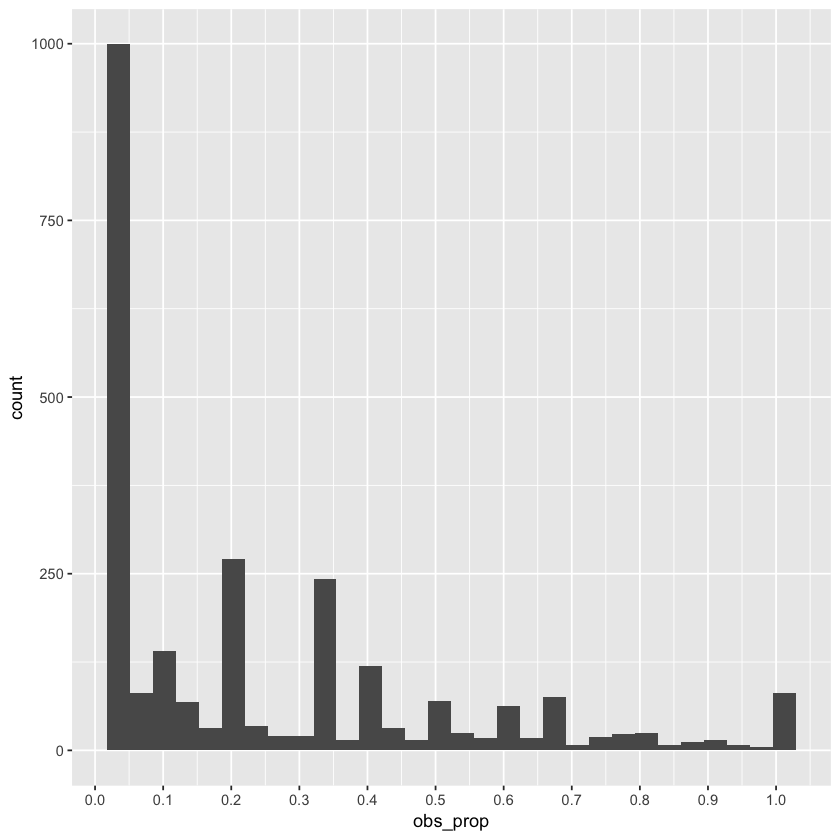

In [15]:
# Count and visualize the proportion of samples with an observation

variants$obs_prop = variants$non_na_obs / variants$N_sample

p1 = ggplot(variants, aes(x=obs_prop)) +
        geom_histogram() +
        scale_x_continuous(breaks = seq(0, 1, len = 11))
p1

In [16]:
# Let's remove 100 % variants as likely ancestral variants

variants = variants[variants$obs_prop <= 0.99,]
nrow(variants) # 2482 variants left

[1] 2482

In [17]:
# Reformat and add treatment information

variants2 = melt(variants[,1:60], id.vars = c("SPECIES","CHROM","POS","REF","ALT","TYPE","EFFECT","IMPACT","GENE","GENEID","HGVS_C","HGVS_P"))
colnames(variants2) =  c("SPECIES","CHROM","POS","REF","ALT","TYPE","EFFECT","IMPACT","GENE","GENEID","HGVS_C","HGVS_P", "SAMPLE", "FREQUENCY")
variants2 = variants2[!is.na(variants2$FREQUENCY),]
variants2 = variants2[order(variants2$SPECIES, variants2$CHROM, variants2$POS),]
variants2$TIME = gsub("_AB.*", "", variants2$SAMPLE)
variants2$TIME = as.numeric(gsub("T", "", variants2$TIME))
variants2$AB = gsub(".*_AB", "", variants2$SAMPLE)
variants2$AB = as.numeric(gsub("_I.*", "", variants2$AB))
variants2$IM = gsub(".*_I", "", variants2$SAMPLE)
variants2$IM = as.factor(as.character(gsub("_REP.*", "", variants2$IM)))
variants2$REP = as.factor(as.character(gsub(".*_REP", "", variants2$SAMPLE)))
head(variants2)

,SPECIES,CHROM,POS,REF,ALT,TYPE,EFFECT,IMPACT,GENE,GENEID,HGVS_C,HGVS_P,SAMPLE,FREQUENCY,TIME,AB,IM,REP
81914,HAMBI_105,IDIPBEOP_1,42374,T,C,snp,missense_variant,MODERATE,cysW_1,IDIPBEOP_00039,c.461T>C,p.Ile154Thr,T8_AB128_I1_REP1,0.5000000,8,128,1,1
81913,HAMBI_105,IDIPBEOP_1,836186,C,A,snp,synonymous_variant,LOW,garB,IDIPBEOP_00850,c.1029G>T,p.Thr343Thr,T8_AB128_I1_REP1,0.6666667,8,128,1,1
81923,HAMBI_105,IDIPBEOP_1,902934,C,T,snp,missense_variant,MODERATE,btrK,IDIPBEOP_00911,c.185C>T,p.Ala62Val,T8_AB128_I1_REP1,0.6666667,8,128,1,1
14919,HAMBI_105,IDIPBEOP_1,942441,A,C,snp,missense_variant,MODERATE,erpA,IDIPBEOP_00947,c.8A>C,p.Asn3Thr,T12_AB128_I0_REP1,0.6666667,12,128,0,1
86898,HAMBI_105,IDIPBEOP_1,1009493,C,T,snp,synonymous_variant,LOW,recG,IDIPBEOP_01017,c.282C>T,p.Phe94Phe,T8_AB128_I1_REP3,0.6666667,8,128,1,3
14921,HAMBI_105,IDIPBEOP_1,1144946,A,G,snp,synonymous_variant,LOW,tufA,IDIPBEOP_01165,c.834T>C,p.Gly278Gly,T12_AB128_I0_REP1,0.7500000,12,128,0,1


In [18]:
# Add median genome coverage data per strain

# Read in data

deep_seq_comb = read.table('../../../data/deep_seq/median_coverage_per_1kb_window.txt', 
                           header = T, 
                           sep = '\t', 
                           check.names = F)

# Reformat

deep_seq_comb$TIME = gsub("_AB.*", "", deep_seq_comb$sample)
deep_seq_comb$TIME = as.numeric(gsub("T", "", deep_seq_comb$TIME))
deep_seq_comb$AB = gsub(".*_AB", "", deep_seq_comb$sample)
deep_seq_comb$AB = as.numeric(gsub("_I.*", "", deep_seq_comb$AB))
deep_seq_comb$IM = gsub(".*_I", "", deep_seq_comb$sample)
deep_seq_comb$IM = as.factor(as.character(gsub("_REP.*", "", deep_seq_comb$IM)))
deep_seq_comb$REP = gsub(".*_REP", "", deep_seq_comb$sample)
deep_seq_comb$SPECIES = paste("HAMBI", deep_seq_comb$strain, sep = "_")
deep_seq_comb = deep_seq_comb[,-c(1:2)]
colnames(deep_seq_comb) = c("MEDIAN_COV",
                            "TIME",
                            "AB",
                            "IM",
                            "REP",
                            "SPECIES")

# Extract only those species with variant data

deep_seq_comb = deep_seq_comb[deep_seq_comb$SPECIES %in% variants2$SPECIES,]

# Add coverage data to variant data table

variants3 = merge(variants2, deep_seq_comb)
head(variants3)

SPECIES,TIME,AB,IM,REP,CHROM,POS,REF,ALT,TYPE,EFFECT,IMPACT,GENE,GENEID,HGVS_C,HGVS_P,SAMPLE,FREQUENCY,MEDIAN_COV
HAMBI_105,12,128,0,1,IDIPBEOP_4,354229,A,G,snp,missense_variant,MODERATE,csxA_2,IDIPBEOP_03284,c.182T>C,p.Leu61Pro,T12_AB128_I0_REP1,0.6666667,74
HAMBI_105,12,128,0,1,IDIPBEOP_1,1145270,C,T,snp,synonymous_variant,LOW,tufA,IDIPBEOP_01165,c.510G>A,p.Ala170Ala,T12_AB128_I0_REP1,1.0000000,74
HAMBI_105,12,128,0,1,IDIPBEOP_6,209669,T,G,snp,missense_variant,MODERATE,cra,IDIPBEOP_03720,c.358A>C,p.Thr120Pro,T12_AB128_I0_REP1,0.8333333,74
HAMBI_105,12,128,0,1,IDIPBEOP_6,236246,A,G,snp,missense_variant,MODERATE,cya,IDIPBEOP_03748,c.2134A>G,p.Ile712Val,T12_AB128_I0_REP1,0.6250000,74
HAMBI_105,12,128,0,1,IDIPBEOP_6,236800,C,T,snp,synonymous_variant,LOW,cya,IDIPBEOP_03748,c.2688C>T,p.Asn896Asn,T12_AB128_I0_REP1,0.7142857,74
HAMBI_105,12,128,0,1,IDIPBEOP_1,1145423,ACGGGCG,GCGAGCA,complex,synonymous_variant,LOW,tufA,IDIPBEOP_01165,c.351_357delCGCCCGTinsTGCTCGC,p.LeuAlaArg117LeuAlaArg,T12_AB128_I0_REP1,1.0000000,74


In [19]:
# Add species abundance data based on 16S rRNA gene amplicon analysis

# Read in data

amplicon_data = read.table('../../../data/amplicon/species_abundance.txt', 
                           header = T, 
                           sep = '\t', 
                           check.names = F)

# Reformat

amplicon_data = melt(amplicon_data, id.vars = "species")
colnames(amplicon_data) = c("SPECIES", "SAMPLE", "AMPLICON_READS")
amplicon_data$TIME = gsub("_AB.*", "", amplicon_data$SAMPLE)
amplicon_data$TIME = as.numeric(gsub("T", "", amplicon_data$TIME))
amplicon_data$AB = gsub(".*_AB", "", amplicon_data$SAMPLE)
amplicon_data$AB = as.numeric(gsub("_I.*", "", amplicon_data$AB))
amplicon_data$IM = gsub(".*_I", "", amplicon_data$SAMPLE)
amplicon_data$IM = as.factor(as.character(gsub("_REP.*", "", amplicon_data$IM)))
amplicon_data$REP = gsub(".*_REP", "", amplicon_data$SAMPLE)
amplicon_data$REP = as.factor(as.character(gsub("_all", "", amplicon_data$REP)))
amplicon_data$SPECIES = paste("HAMBI", amplicon_data$SPECIES, sep = "_")
amplicon_data = amplicon_data[,-2]

# Extract only those species with variant data

amplicon_data = amplicon_data[amplicon_data$SPECIES %in% variants3$SPECIES,]

# Add amplicon data to variant data table

variants4 = merge(variants3, amplicon_data, all.x = T)
head(variants4)

SPECIES,TIME,AB,IM,REP,CHROM,POS,REF,ALT,TYPE,EFFECT,IMPACT,GENE,GENEID,HGVS_C,HGVS_P,SAMPLE,FREQUENCY,MEDIAN_COV,AMPLICON_READS
HAMBI_105,12,128,0,1,IDIPBEOP_4,354229,A,G,snp,missense_variant,MODERATE,csxA_2,IDIPBEOP_03284,c.182T>C,p.Leu61Pro,T12_AB128_I0_REP1,0.6666667,74,70
HAMBI_105,12,128,0,1,IDIPBEOP_1,1145270,C,T,snp,synonymous_variant,LOW,tufA,IDIPBEOP_01165,c.510G>A,p.Ala170Ala,T12_AB128_I0_REP1,1.0000000,74,70
HAMBI_105,12,128,0,1,IDIPBEOP_6,209669,T,G,snp,missense_variant,MODERATE,cra,IDIPBEOP_03720,c.358A>C,p.Thr120Pro,T12_AB128_I0_REP1,0.8333333,74,70
HAMBI_105,12,128,0,1,IDIPBEOP_6,236246,A,G,snp,missense_variant,MODERATE,cya,IDIPBEOP_03748,c.2134A>G,p.Ile712Val,T12_AB128_I0_REP1,0.6250000,74,70
HAMBI_105,12,128,0,1,IDIPBEOP_6,236800,C,T,snp,synonymous_variant,LOW,cya,IDIPBEOP_03748,c.2688C>T,p.Asn896Asn,T12_AB128_I0_REP1,0.7142857,74,70
HAMBI_105,12,128,0,1,IDIPBEOP_1,1145423,ACGGGCG,GCGAGCA,complex,synonymous_variant,LOW,tufA,IDIPBEOP_01165,c.351_357delCGCCCGTinsTGCTCGC,p.LeuAlaArg117LeuAlaArg,T12_AB128_I0_REP1,1.0000000,74,70


In [20]:
# Inspect variant effects

unique(variants4$EFFECT)

[1] missense_variant                                  
 [2] synonymous_variant                                
 [3] upstream_gene_variant                             
 [4] stop_gained                                       
 [5] frameshift_variant                                
 [6] intragenic_variant                                
 [7] downstream_gene_variant                           
 [8] intergenic_region                                 
 [9] conservative_inframe_deletion                     
[10] conservative_inframe_insertion                    
[11] frameshift_variant&synonymous_variant             
[12] stop_lost&splice_region_variant                   
[13] disruptive_inframe_insertion                      
[14] frameshift_variant&missense_variant               
[15] frameshift_variant&stop_lost&splice_region_variant
[16] synonymous_variant&conservative_inframe_insertion 
[17] frameshift_variant&splice_region_variant          
[18] splice_region_variant&stop_retained_variant       
[19] initiator_codon_variant                           
[20] disruptive_inframe_deletion                       
37 Levels: conservative_inframe_deletion ... frameshift_variant&stop_gained

In [21]:
# Add reduced variant effect categories (synonymous, nonsynonymous or noncoding)

variants4$EFFECT = as.factor(as.character(variants4$EFFECT))
variants4$EFFECT_CAT = NA
variants4$EFFECT_CAT = ifelse(grepl("missense_variant", variants4$EFFECT), "nonsynonymous", variants4$EFFECT_CAT)
variants4$EFFECT_CAT = ifelse(grepl("synonymous_variant", variants4$EFFECT), "synonymous", variants4$EFFECT_CAT)
variants4$EFFECT_CAT = ifelse(grepl("upstream_gene_variant", variants4$EFFECT), "noncoding", variants4$EFFECT_CAT)
variants4$EFFECT_CAT = ifelse(grepl("stop_gained", variants4$EFFECT), "nonsynonymous", variants4$EFFECT_CAT)
variants4$EFFECT_CAT = ifelse(grepl("frameshift_variant", variants4$EFFECT), "nonsynonymous", variants4$EFFECT_CAT)
variants4$EFFECT_CAT = ifelse(grepl("intragenic_variant", variants4$EFFECT), "noncoding", variants4$EFFECT_CAT)
variants4$EFFECT_CAT = ifelse(grepl("downstream_gene_variant", variants4$EFFECT), "noncoding", variants4$EFFECT_CAT)
variants4$EFFECT_CAT = ifelse(grepl("intergenic_region", variants4$EFFECT), "noncoding", variants4$EFFECT_CAT)
variants4$EFFECT_CAT = ifelse(grepl("conservative_inframe_deletion", variants4$EFFECT), "synonymous", variants4$EFFECT_CAT)
variants4$EFFECT_CAT = ifelse(grepl("conservative_inframe_insertion", variants4$EFFECT), "synonymous", variants4$EFFECT_CAT)
variants4$EFFECT_CAT = ifelse(grepl("frameshift_variant&synonymous_variant", variants4$EFFECT), "nonsynonymous", variants4$EFFECT_CAT)
variants4$EFFECT_CAT = ifelse(grepl("stop_lost&splice_region_variant", variants4$EFFECT), "nonsynonymous", variants4$EFFECT_CAT)
variants4$EFFECT_CAT = ifelse(grepl("disruptive_inframe_insertion", variants4$EFFECT), "nonsynonymous", variants4$EFFECT_CAT)
variants4$EFFECT_CAT = ifelse(grepl("frameshift_variant&missense_variant", variants4$EFFECT), "nonsynonymous", variants4$EFFECT_CAT)
variants4$EFFECT_CAT = ifelse(grepl("frameshift_variant&stop_lost&splice_region_variant", variants4$EFFECT), "nonsynonymous", variants4$EFFECT_CAT)
variants4$EFFECT_CAT = ifelse(grepl("synonymous_variant&conservative_inframe_insertion", variants4$EFFECT), "synonymous", variants4$EFFECT_CAT)
variants4$EFFECT_CAT = ifelse(grepl("frameshift_variant&splice_region_variant", variants4$EFFECT), "nonsynonymous", variants4$EFFECT_CAT)
variants4$EFFECT_CAT = ifelse(grepl("splice_region_variant&stop_retained_variant", variants4$EFFECT), "synonymous", variants4$EFFECT_CAT)
variants4$EFFECT_CAT = ifelse(grepl("initiator_codon_variant", variants4$EFFECT), "nonsynonymous", variants4$EFFECT_CAT)
variants4$EFFECT_CAT = ifelse(grepl("disruptive_inframe_deletion", variants4$EFFECT), "nonsynonymous", variants4$EFFECT_CAT)
unique(variants4$EFFECT_CAT)

[1] "nonsynonymous" "synonymous"    "noncoding"

In [22]:
# Reformat and add explicit column names

variants4 = variants4[,c(17,2:5,1,6:11,21,12:16,18:20)]
colnames(variants4) = c("SAMPLE",
                        "TIME",
                        "ANTIBIOTIC",
                        "IMMIGRATION",
                        "REPLICATE",
                        "SPECIES",
                        "CONTIG",
                        "POSITION",
                        "REF_ALLELE",
                        "ALT_ALLELE",
                        "VARIANT_TYPE",
                        "VARIANT_EFFECT",
                        "VARIANT_EFFECT_CAT",
                        "VARIANT_IMPACT",
                        "GENE",
                        "GENEID",
                        "NA_CHANGE",
                        "AA_CHANGE",
                        "VARIANT_FREQUENCY",
                        "MEDIAN_COVERAGE",
                        "AMPLICON_READS")
variants4 = variants4[order(variants4$SPECIES, variants4$CONTIG, variants4$POSITION),]
head(variants4)

,SAMPLE,TIME,ANTIBIOTIC,IMMIGRATION,REPLICATE,SPECIES,CONTIG,POSITION,REF_ALLELE,ALT_ALLELE,⋯,VARIANT_EFFECT,VARIANT_EFFECT_CAT,VARIANT_IMPACT,GENE,GENEID,NA_CHANGE,AA_CHANGE,VARIANT_FREQUENCY,MEDIAN_COVERAGE,AMPLICON_READS
50,T8_AB128_I1_REP1,8,128,1,1,HAMBI_105,IDIPBEOP_1,42374,T,C,⋯,missense_variant,nonsynonymous,MODERATE,cysW_1,IDIPBEOP_00039,c.461T>C,p.Ile154Thr,0.5000000,58,14
51,T8_AB128_I1_REP1,8,128,1,1,HAMBI_105,IDIPBEOP_1,836186,C,A,⋯,synonymous_variant,synonymous,LOW,garB,IDIPBEOP_00850,c.1029G>T,p.Thr343Thr,0.6666667,58,14
52,T8_AB128_I1_REP1,8,128,1,1,HAMBI_105,IDIPBEOP_1,902934,C,T,⋯,missense_variant,nonsynonymous,MODERATE,btrK,IDIPBEOP_00911,c.185C>T,p.Ala62Val,0.6666667,58,14
9,T12_AB128_I0_REP1,12,128,0,1,HAMBI_105,IDIPBEOP_1,942441,A,C,⋯,missense_variant,nonsynonymous,MODERATE,erpA,IDIPBEOP_00947,c.8A>C,p.Asn3Thr,0.6666667,74,70
67,T8_AB128_I1_REP3,8,128,1,3,HAMBI_105,IDIPBEOP_1,1009493,C,T,⋯,synonymous_variant,synonymous,LOW,recG,IDIPBEOP_01017,c.282C>T,p.Phe94Phe,0.6666667,62,21
11,T12_AB128_I0_REP1,12,128,0,1,HAMBI_105,IDIPBEOP_1,1144946,A,G,⋯,synonymous_variant,synonymous,LOW,tufA,IDIPBEOP_01165,c.834T>C,p.Gly278Gly,0.7500000,74,70


In [23]:
# Add distance from previous variant

contigs = as.vector(unique(variants4$CONTIG))
dist_list=list()
for(i in 1:length(contigs)){
  a = variants4[variants4$CONTIG == contigs[i],]
  b = as.vector(sort(unique(a$POSITION)))
  c = c(b[1],b[-length(b)])
  d = b-c
  e = as.data.frame(cbind(b,d))
  colnames(e) = c("POSITION","DISTANCE_FROM_PREV")
  e$CONTIG = contigs[i]
  dist_list[[i]] = e
}

distance=Reduce(function(...) merge(..., all = T), dist_list)

# Add distance data to variant data table
                
variants5 = merge(variants4, distance, all.x = T)
head(variants5)

CONTIG,POSITION,SAMPLE,TIME,ANTIBIOTIC,IMMIGRATION,REPLICATE,SPECIES,REF_ALLELE,ALT_ALLELE,⋯,VARIANT_EFFECT_CAT,VARIANT_IMPACT,GENE,GENEID,NA_CHANGE,AA_CHANGE,VARIANT_FREQUENCY,MEDIAN_COVERAGE,AMPLICON_READS,DISTANCE_FROM_PREV
ABNHBPOL_1,130054,T12_AB16_I0_REP3,12,16,0,3,HAMBI_1972,G,T,⋯,nonsynonymous,MODERATE,ABNHBPOL_00101,ABNHBPOL_00101,c.653C>A,p.Thr218Asn,0.5000000,439,550,65183
ABNHBPOL_1,204875,T8_AB4_I1_REP1,8,4,1,1,HAMBI_1972,G,T,⋯,nonsynonymous,MODERATE,hscA,ABNHBPOL_00169,c.1013G>T,p.Arg338Leu,0.6666667,163,169,74821
ABNHBPOL_1,277408,T12_AB0_I0_REP1,12,0,0,1,HAMBI_1972,T,C,⋯,noncoding,MODIFIER,hns_1,ABNHBPOL_00236,c.-4987A>G,NA,1.0000000,604,4103,72533
ABNHBPOL_1,277408,T12_AB0_I0_REP2,12,0,0,2,HAMBI_1972,T,C,⋯,noncoding,MODIFIER,hns_1,ABNHBPOL_00236,c.-4987A>G,NA,1.0000000,569,2768,72533
ABNHBPOL_1,277408,T12_AB0_I0_REP3,12,0,0,3,HAMBI_1972,T,C,⋯,noncoding,MODIFIER,hns_1,ABNHBPOL_00236,c.-4987A>G,NA,1.0000000,452,2138,72533
ABNHBPOL_1,277408,T12_AB0_I1_REP1,12,0,1,1,HAMBI_1972,T,C,⋯,noncoding,MODIFIER,hns_1,ABNHBPOL_00236,c.-4987A>G,NA,1.0000000,551,1886,72533


In [24]:
# Add contig length data

# Read in data

contig_length = read.table("../../../data/deep_seq/contig_length.txt")

# Reformat

colnames(contig_length) = c("CONTIG", "CONTIG_LENGTH")
contig_length$CONTIG = gsub("[gln|X|]", "", contig_length$CONTIG)
contig_length$CONTIG = as.factor(contig_length$CONTIG)

# Add contig length data to variant data table

variants6 = merge(variants5, contig_length, by = "CONTIG")

# Reformat variant data table

variants6 = variants6[,c(3:8, 1, 23, 2, 9:22)]
head(variants6)

SAMPLE,TIME,ANTIBIOTIC,IMMIGRATION,REPLICATE,SPECIES,CONTIG,CONTIG_LENGTH,POSITION,REF_ALLELE,⋯,VARIANT_EFFECT_CAT,VARIANT_IMPACT,GENE,GENEID,NA_CHANGE,AA_CHANGE,VARIANT_FREQUENCY,MEDIAN_COVERAGE,AMPLICON_READS,DISTANCE_FROM_PREV
T12_AB16_I0_REP3,12,16,0,3,HAMBI_1972,ABNHBPOL_1,404185,130054,G,⋯,nonsynonymous,MODERATE,ABNHBPOL_00101,ABNHBPOL_00101,c.653C>A,p.Thr218Asn,0.5000000,439,550,65183
T8_AB4_I1_REP1,8,4,1,1,HAMBI_1972,ABNHBPOL_1,404185,204875,G,⋯,nonsynonymous,MODERATE,hscA,ABNHBPOL_00169,c.1013G>T,p.Arg338Leu,0.6666667,163,169,74821
T12_AB0_I0_REP1,12,0,0,1,HAMBI_1972,ABNHBPOL_1,404185,277408,T,⋯,noncoding,MODIFIER,hns_1,ABNHBPOL_00236,c.-4987A>G,NA,1.0000000,604,4103,72533
T12_AB0_I0_REP2,12,0,0,2,HAMBI_1972,ABNHBPOL_1,404185,277408,T,⋯,noncoding,MODIFIER,hns_1,ABNHBPOL_00236,c.-4987A>G,NA,1.0000000,569,2768,72533
T12_AB0_I0_REP3,12,0,0,3,HAMBI_1972,ABNHBPOL_1,404185,277408,T,⋯,noncoding,MODIFIER,hns_1,ABNHBPOL_00236,c.-4987A>G,NA,1.0000000,452,2138,72533
T12_AB0_I1_REP1,12,0,1,1,HAMBI_1972,ABNHBPOL_1,404185,277408,T,⋯,noncoding,MODIFIER,hns_1,ABNHBPOL_00236,c.-4987A>G,NA,1.0000000,551,1886,72533


In [25]:
# Write out

write.table(variants6, row.names = FALSE, "../../../data/deep_seq/downsampled_filtered_variant_data.txt", sep = "\t")